# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pycewise
print(f'pycewise {pycewise.__version__}')
print(f'pycewise {pycewise.__git_version__}')

directory = 'pycewise_demo/1/'
archives = [directory + f for f in os.listdir(directory)]

threshold = 64000  # "semantic" breakpoint, found with another script

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.SafeLoader)

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    cluster = result['info.yaml']['cluster']
    dataframes = []
    for exp, df in {
            'pingpong': df_pingpong,
            'send'  : pingpong_send,
            'isend' : result['exp/exp_Isend.csv'],
            'recv'  : result['exp/exp_Recv.csv'],
            'wtime' : result['exp/exp_Wtime.csv'],
            'test'  : result['exp/exp_Test.csv'],
            'iprobe': result['exp/exp_Iprobe.csv'],
        }.items():
        df['experiment'] = exp
        dataframes.append(df)
    dataframes = pandas.concat(dataframes)
    dataframes['cluster'] = cluster
    return dataframes

pycewise 0.1.2
pycewise 27f261d5aada4d0bce84394bfe29d3cd3bc89d46


In [2]:
df = pandas.concat([load_experiment(arch) for arch in archives])

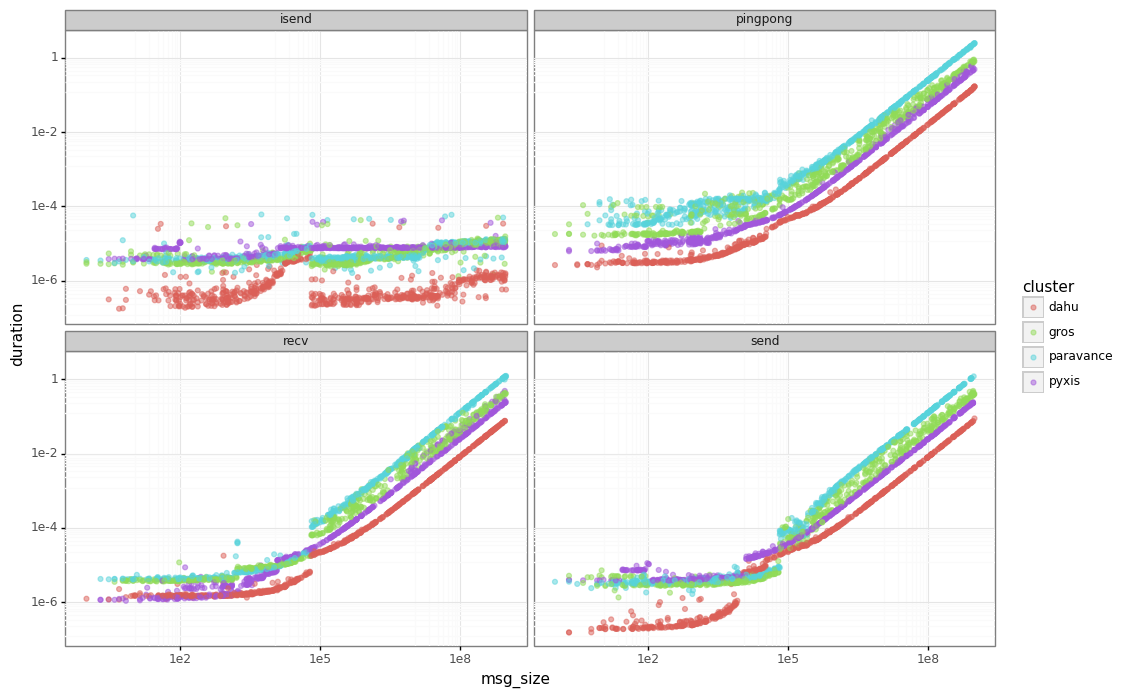

<ggplot: (-9223363299137764569)>

In [3]:
(ggplot(df[~df['experiment'].isin(['iprobe', 'wtime', 'test'])].sample(n=10000))
    + aes(x='msg_size', y='duration', color='cluster')
    + geom_point(alpha=0.5)
    + facet_wrap('experiment')
    + theme_bw()
    + scale_x_log10() + scale_y_log10()
)

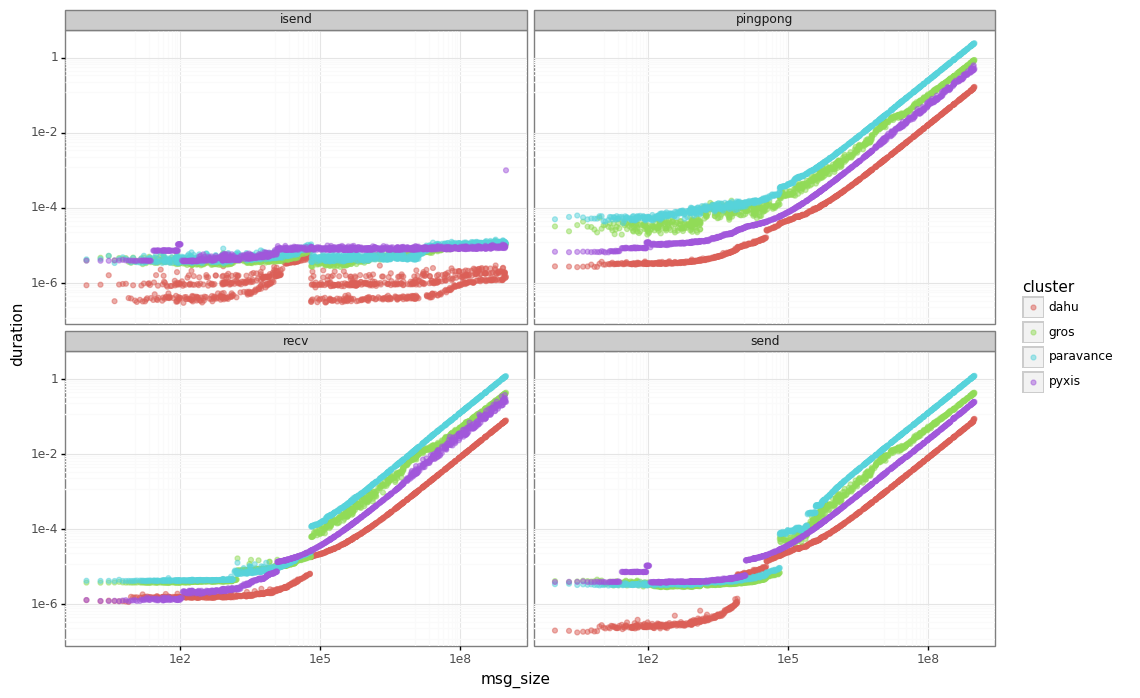

<ggplot: (8737699266529)>

In [4]:
grouped = df[~df['experiment'].isin(['iprobe', 'wtime', 'test'])].groupby(['experiment', 'cluster', 'msg_size'])[['duration']].mean().reset_index()
(ggplot(grouped)
    + aes(x='msg_size', y='duration', color='cluster')
    + geom_point(alpha=0.5)
    + facet_wrap('experiment')
    + theme_bw()
    + scale_x_log10() + scale_y_log10()
)                           

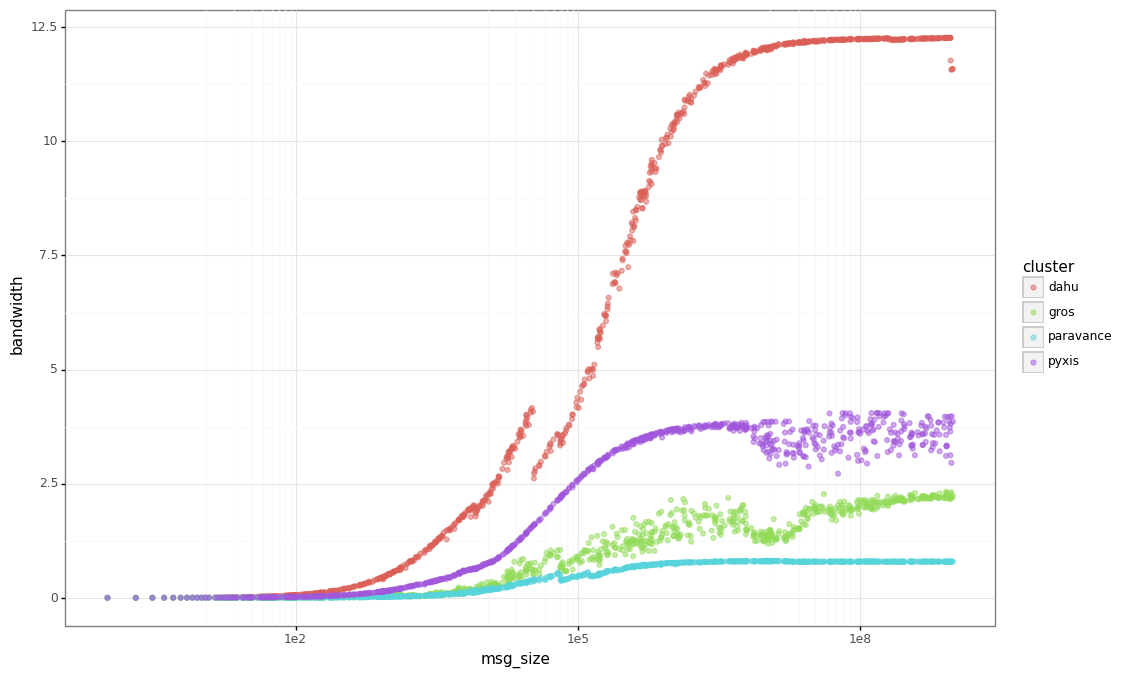

<ggplot: (8737696603442)>

In [5]:
tmp = grouped[grouped['experiment'] == 'pingpong'].copy()
tmp['bandwidth'] = 2*tmp['msg_size'] / tmp['duration'] * 1e-9
(ggplot(tmp)
    + aes(x='msg_size', y='bandwidth', color='cluster')
    + geom_point(alpha=0.5)
    + theme_bw()
    + scale_x_log10()
)   

In [6]:
sizes = set(grouped['msg_size'].drop_duplicates().sample(n=200, random_state=42))
tmp = grouped[grouped['msg_size'].isin(sizes)]
tmp

,experiment,cluster,msg_size,duration
2,isend,dahu,3,1.608860e-06
5,isend,dahu,6,9.417600e-07
7,isend,dahu,8,3.964800e-07
10,isend,dahu,11,3.406600e-07
23,isend,dahu,27,3.525800e-07
...,...,...,...,...
13346,send,pyxis,824340897,2.098105e-01
13347,send,pyxis,834006358,2.175566e-01
13352,send,pyxis,904353910,2.344472e-01
13355,send,pyxis,919121286,2.440539e-01


In [7]:
tmp.to_csv('/tmp/pycewise_data.csv', index=False)